# Diferenciación Automática (v2)

En este colab vamos a explorar una implementación de un grafo de cómputo y algunas operaciones soportadas (podríamos agregarle todas las que querramos), permitiendo por diferenciación automática el cálculo de las derivadas de una función arbitrariamente compleja respecto de sus entradas.

In [63]:
import math
from graphviz import Digraph

In [64]:
# helper function for subsetting a dict
def subset(X: dict, keys: set) -> dict:
    return {k:v for k,v in X.items() if k in keys}

# an example
sample_dict = {'a': 1, 'b':2, 'c':3, 'd':4, 'e':5}
sample_keys = {'b','d'}
subset(sample_dict, sample_keys)

{'b': 2, 'd': 4}

In [65]:
class ComputeGraph:
    def __init__(self, *inputs, debug=False):
        self.g = {input:None for input in inputs}
        self.inputs = set(inputs)
        self.debug = debug

    def __setitem__(self, var, operation):
        # do not allow placing a new op on a used name
        assert var not in self.g, f"var name {var} already exists"

        # check that all parents of new operation already exist in the graph
        # for sets, A < B holds if B contains A
        assert set(operation.inputs) <= set(self.g), f"Vars {set(operation.inputs) - set(self.g)} do not exist in graph"
        # add op to graph
        self.g[var] = operation

    def __call__(self, **kwords):
        return self.forward(**kwords)

    def forward(self, **kwords):
        # check given inputs are exactly the ones expected by the graph
        assert set(kwords.keys()) == self.inputs, f"Given inputs {kwords} do not match expected inputs {self.inputs}"

        # initialize values dict
        self.values = {var:{"f":0, "df":0} for var in self.g}


        # travel the graph
        ## Note: this exploits std dict remembering insertion order since 3.7
        for var, op in self.g.items():

            if var in self.inputs:
                # value of an input is the passed one
                value = kwords[var]
            else:
                # value of an op requires evaluating it
                value = op.f(self.values)

            # debug, possibly
            if self.debug:
                print("Forward:\t", var,"=",value)

            # save it
            self.values[var]["f"] = value

            # only last one will not be overwritten
            self.output = var

        # return the last one
        return value

    def backwards(self):
        # travel the graph in reverse order
        for var, op in reversed(self.g.items()):

            # the output is the last op, hence df is 1
            if var == self.output:
                self.values[var]["df"] = 1

            accumulated_df = self.values[var]["df"]

            # if it's an input, skip accumulating dfs (inputs have no parents)
            if var in self.inputs:
                continue

            # accumulate derivatives and add to parents
            for parent, derivative in op.df().items():
                # dF/dx = dF/dy * dy/dx
                # dF/dy is accumulated_df
                # dy/dx is the derivative from op
                self.values[parent]["df"] += accumulated_df * derivative

                # debug, possibly
                if self.debug:
                    print("Backwards:\t", var,"->",parent,"=",accumulated_df,"*",derivative)

        # return derivatives for inputs
        return {var:values["df"] for var,values in self.values.items() if var in self.inputs}

    def plot(self, vertical=True, use_op_names=True):
        d = Digraph(format='svg', graph_attr={'rankdir': 'TB' if vertical else 'LR'})

        for var, op in self.g.items():
            if var in self.inputs:
                d.node(var, var + "| Input", shape='record')
                continue
            if use_op_names:
                label = "|" + op.get_op_name()
            else:
                label = " = " + str(op)
            d.node(var, var + label, shape='record')
            d.edges([(parent, var) for parent in op.inputs])

        return d

In [66]:
class Operation:
    def __init__(self, *inputs):
        self.inputs = inputs

    def f(self, value_graph):
        self.last_inputs = [value_graph[x]["f"] for x in self.inputs]
        return self.forward(*self.last_inputs)

    def df(self):
        gradient = self.backwards(*self.last_inputs)

        # if it's a scalar, convert to a 1-dim gradient
        if not isinstance(gradient,tuple):
            gradient = (gradient,)
        return {var:derivative for var,derivative in zip(self.inputs, gradient)}

    def get_op_name(self):
        # for plotting purposes
        return self.__class__.__name__

    def __str__(self):
        # for plotting purposes
        return self.FMT % self.inputs

In [67]:
class Power(Operation):
    FMT = "%s ^ %s"

    def forward(self, base, exp):
        """base ^ exp """
        return base**exp

    def backwards(self, base, exp):
        """
        derivative of x^k is k*x^{k-1}
        derivative of k^x is k^x * log(k)
        """
        return (
            exp* base**(exp-1),
            base**exp * math.log(base)
        )

In [68]:
class Square(Operation):
    FMT = "%s ^ 2"

    def forward(self, base):
        return base**2

    def backwards(self, base):
        return 2*base

In [69]:
class Product(Operation):
    FMT = "%s * %s"

    def forward(self, a, b):
        """a * b"""
        return a * b

    def backwards(self, a, b):
        """
        derivative of x*b is b
        derivative of a*x is a
        """
        return (b,a)

In [70]:
class Cosine(Operation):
    FMT = "cos(%s)"

    def forward(self, x):
        """cos(x)"""
        return math.cos(x)

    def backwards(self, x):
        """
        derivative of cos(x) is -sin(x)
        """
        return -math.sin(x)

## Código de prueba

Empecemos con una fácil: $x^{cos(x)}$

Veámosla para $x=3$, que debería dar, según [Wolfram Alpha](https://www.wolframalpha.com/input?i=derivative+of+x%5E%7Bcos%28x%29%7D+at+x%3D3&lang=es), $-0.163465$

Lo vamos a plantear de la siguiente manera:
```
x
y = cos(x)
z = x^y
```

Donde z es la salida

In [71]:
cg = ComputeGraph("x", debug=True)
cg["y"] = Cosine("x")
cg["z"] = Power("x", "y")

In [72]:
cg(x=3)

Forward:	 x = 3
Forward:	 y = -0.9899924966004454
Forward:	 z = 0.3370183421202187


0.3370183421202187

In [73]:
cg.backwards()

Backwards:	 z -> x = 1 * -0.11121520997191278
Backwards:	 z -> y = 1 * 0.3702524921598255
Backwards:	 y -> x = 0.3702524921598255 * -0.1411200080598672


{'x': -0.16346524464969328}

Ahora vamos con algo un poquito más dificil, $x^{cos(y) \cdot z^2}$. Probémoslo para $x=2, y=3, z=1.5$, que según [Wolfram Alpha](https://www.wolframalpha.com/input?i=derivatives+of+x%5E%7Bcos%28y%29*z%5E2%7D&lang=es), debería dar [-0.237818](https://www.wolframalpha.com/input?i=x%5E%28-1+%2B+z%5E2+cos%28y%29%29+z%5E2+cos%28y%29+at+x%3D2%2C+y%3D3%2C+z%3D1.5&lang=es), [-0.0469956](https://www.wolframalpha.com/input?i=-x%5E%28z%5E2+cos%28y%29%29+z%5E2+log%28x%29+sen%28y%29+at+x%3D2%2C+y%3D3%2C+z%3D1.5&lang=es), [-0.439581](https://www.wolframalpha.com/input?i=2+x%5E%28z%5E2+cos%28y%29%29+z+cos%28y%29+log%28x%29+at+x%3D2%2C+y%3D3%2C+z%3D1.5&lang=es)


Lo vamos a hacer así:
```
x, y, z
a = cos(y)
b = z^2
c = a*b
d = x^c
```

Donde d es la salida

In [74]:
cg = ComputeGraph("x","y","z")
cg["a"] = Cosine("y")
cg["b"] = Square("z")
cg["c"] = Product("a","b")
cg["d"] = Power("x","c")

cg(x=2,y=3,z=1.5)

0.21353091784478878

In [75]:
cg.backwards()

{'x': -0.23781825726586542,
 'y': -0.04699561514027202,
 'z': -0.43958147869203823}

Ploteemos este último grafo de computo:

Primero usamos los tipos de las operaciones (con `use_op_names=True`, el valor default)

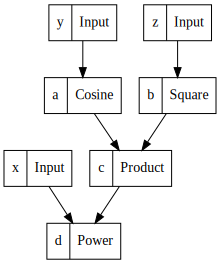

In [76]:
cg.plot(use_op_names=True)

Ahora en formato más "humano" con `use_op_names=False`

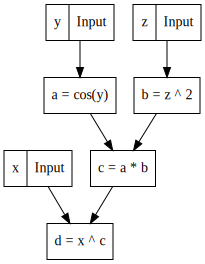

In [77]:
cg.plot(use_op_names=False)

Si cambiamos el parámetro `vertical=False` pasa a ser horizontal

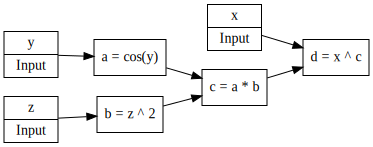

In [78]:
cg.plot(use_op_names=False,vertical=False)